# train_incep4.py:

In [11]:
# train_incep3.py

import os
import sys
import numpy as np
import shutil

from inception_v4 import create_model, preprocess_input  # Import both functions
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K

# Set data format to 'channels_last' to align with pre-trained weights
K.set_image_data_format('channels_last')  # Ensure this matches your data

def add_random_noise(image):
    """
    Adds random noise to the image based on defined probabilities.
    """
    if np.random.rand() > 0.4:
        if np.random.rand() > 0.5:
            return add_noise(image, 'gauss')
        else:
            return add_noise(image, 's&p')
    else:
        return image

def add_noise(image, noise_typ='gauss'):
    """
    Adds specified type of noise to the image.
    """
    maxv = max(1, np.max(image))
    
    if noise_typ == "gauss":
        mean = 0
        var = 0.1 * maxv
        sigma = var**0.5
        gauss = np.random.normal(mean, sigma, image.shape)
        noisy = image + gauss
        return noisy
    elif noise_typ == "s&p":
        s_vs_p = 0.5
        amount = 0.004
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
        out[tuple(coords)] = maxv
        
        # Pepper mode
        num_pepper = np.ceil(amount * image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
        out[tuple(coords)] = 0
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ == "speckle":
        gauss = np.random.randn(*image.shape)
        noisy = image + image * gauss
        return noisy

############################################################
## Fine-tune InceptionV4 on a new set of classes
def build_inceptionV4(input_shape=(200, 200, 3)):  # Set input_shape to (200, 200, 3)
    """
    Builds the InceptionV4 model with custom top layers.

    Args:
        input_shape (tuple): Shape of the input images.

    Returns:
        base_model (keras.Model): The base InceptionV4 model without top layers.
        model (keras.Model): The complete InceptionV4 model with custom top layers.
    """
    if K.image_data_format() == 'channels_first':
        keras_input_shape = (3, input_shape[0], input_shape[1])
    else:
        keras_input_shape = input_shape  # (200, 200, 3)

    base_model = create_model(
        num_classes=1001, 
        dropout_prob=0.2, 
        weights='imagenet', 
        include_top=False, 
        input_shape=keras_input_shape
    )

    # Add custom top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(2, activation='softmax')(x)  # Assuming 2 classes

    # Define the new model
    model = Model(inputs=base_model.input, outputs=predictions)

    return base_model, model

def main(argv = ['ds1', 'None', '0']):
    """
    Main function to train the InceptionV4 model.

    Args:
        argv (list): Command-line arguments.
                    argv[0]: Dataset directory.
                    argv[1]: Path to resume model (optional).
                    argv[2]: Flag to add image noise (0 or 1).
    """
    ds = argv[0]
    resume_model = None
    if len(argv) > 1:
        resume_model = argv[1] if argv[1] != 'None' else None
    im_noise = False
    if len(argv) > 2:
        im_noise = int(argv[2]) == 1
    
    nb_epoch2 = 30

    if not os.path.exists('models'):
        os.mkdir('models')
    
    ## Define ImageDataGenerators for training and validation
    train_datagen = ImageDataGenerator(
        preprocessing_function=add_random_noise if im_noise else preprocess_input,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.02,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.02,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True  # randomly flip images
    )
    
    valid_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,  # No augmentation for validation
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False
    )
    
    # Flow training images in batches using train_datagen
    train_generator = train_datagen.flow_from_directory(
        os.path.join(ds, 'train'),
        target_size=(200, 200),  # Set target_size to (200, 200)
        color_mode='rgb',
        batch_size=40,
        class_mode='categorical',
        shuffle=True
    )
    
    # Flow validation images in batches using valid_datagen
    valid_generator = valid_datagen.flow_from_directory(
        os.path.join(ds, 'valid'),
        target_size=(200, 200),  # Set target_size to (200, 200)
        color_mode='rgb',
        batch_size=40,
        class_mode='categorical',
        shuffle=False
    )
    
    ## Build model
    base_model, model = build_inceptionV4(input_shape=(200, 200, 3))

    if resume_model is not None:
        print('Resume model: ', resume_model)
        model.load_weights(resume_model)
    
    # Compile the model
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Print model summary to verify architecture
    model.summary()
    
    # Define callbacks
    filepath2 = os.path.join("models", f"{ds}_incep4-{{epoch:02d}}-{{val_accuracy:.3f}}.hdf5")
    checkpoint2 = ModelCheckpoint(filepath2, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
    
    early_stopper = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=40, verbose=1)
    
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, verbose=1)
    
    callbacks_list2 = [early_stopper, checkpoint2, reduce_lr]
    
    # Calculate steps per epoch
    nTrainSample = train_generator.samples
    steps_per_epoch = np.ceil(nTrainSample / 40)
    
    # Calculate validation steps
    nValidSample = valid_generator.samples
    validation_steps = np.ceil(nValidSample / 40)
    
    # Optional: Freeze base model layers initially
    # Uncomment the following lines if you wish to freeze the base model layers during initial training
    # for layer in base_model.layers:
    #     layer.trainable = False
    
    # Train the model 
    model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=nb_epoch2,
        validation_data=valid_generator,
        validation_steps=validation_steps,
        callbacks=callbacks_list2
    )
    
    # Serialize last weights to HDF5
    last_weights_path = os.path.join("models", f"{ds}_incep4-{nb_epoch2}.hdf5")
    model.save_weights(last_weights_path)
    
    print("Saved last weights to disk")

if __name__ == "__main__":
    main()


Found 80 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv2d_159 (Conv2D)         (None, 99, 99, 32)           864       ['input_7[0][0]']             
                                                                                                  
 batch_normalization_154 (B  (None, 99, 99, 32)           96        ['conv2d_159[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_15

Loading weights from: models/ds1_incep4-30.hdf5
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv2d_606 (Conv2D)         (None, 99, 99, 32)           864       ['input_10[0][0]']            
                                                                                                  
 batch_normalization_601 (B  (None, 99, 99, 32)           96        ['conv2d_606[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_601 (Activation  (None, 99, 99, 

/mnt/f/IIT_KANPUR_ROHAN/SEMESTERS/7th_Sem/CS786/Assignment/roh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


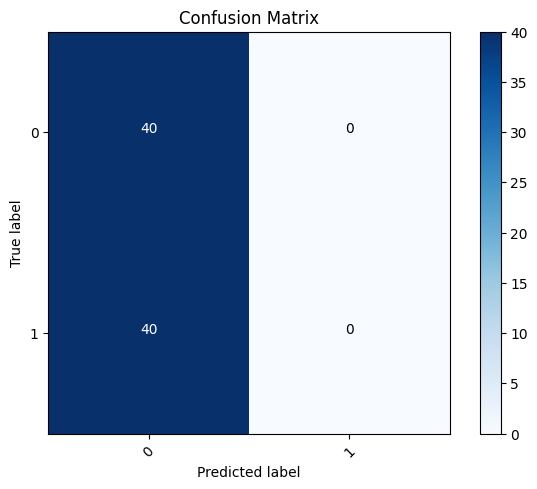

In [14]:
import os
import sys
import numpy as np
import shutil
from scipy import misc  # Note: `misc.imsave` is deprecated; consider using `imageio` or `PIL` instead
from sklearn import metrics
import matplotlib.pyplot as plt
# import pdb

from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Input
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, roc_curve, auc

from inception_v4 import create_model, preprocess_input  # Import functions from inception_v4.py
from datetime import datetime

# Set data format to 'channels_last' to align with InceptionV4
K.set_image_data_format('channels_last')


def evaluate(gt, p):
    """
    Calculate the log loss.
    """
    gt = np.asarray(gt)
    p = np.asarray(p)
    tmp = np.array([np.array([p, np.ones(len(gt)) * (1 - 1e-15)]).min(axis=0),
                    np.ones(len(gt)) * 1e-15]).max(axis=0)
    logloss = -np.sum(gt * np.log(tmp) + (1 - gt) * np.log(1 - tmp)) / float(len(gt))
    return logloss


def get_error(gt, p):
    """
    Calculate the error rate.
    """
    gt = np.asarray(gt)
    p = np.asarray(p).astype(np.int8)
    error = np.sum(np.not_equal(gt, p))
    return float(error) / len(gt)


def get_confusion_matrix(gt, p):
    """
    Compute the confusion matrix.
    """
    gt = np.asarray(gt)
    p = np.asarray(p).astype(np.int8)
    tp = np.sum(np.logical_and(gt == 1, p == 1))
    tn = np.sum(np.logical_and(gt == 0, p == 0))
    fp = np.sum(np.logical_and(gt == 0, p == 1))
    fn = np.sum(np.logical_and(gt == 1, p == 0))
    return ((tn, fp), (fn, tp))


# Create output directory if it doesn't exist
output_dir = "output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


# When saving plots, use timestamp and plot type for unique naming
def save_plot(plt, plot_type):
    """
    Save the plot with a unique timestamped filename.
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{output_dir}/{plot_type}_{timestamp}.png"
    plt.savefig(filename)
    plt.close()
    print(f"Plot saved as: {filename}")


############################################################
## Define InceptionV4-based model for testing
def build_inceptionV4(input_shape=(200, 200, 3), num_classes=2):
    """
    Builds the InceptionV4 model with custom top layers for testing.

    Args:
        input_shape (tuple): Shape of the input images.
        num_classes (int): Number of classes for classification.

    Returns:
        model (keras.Model): InceptionV4 model instance.
    """
    # Create the base InceptionV4 model without the top layers
    base_model = create_model(
        num_classes=1001,  # Original number of classes for ImageNet
        dropout_prob=0.2,
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Add custom top layers suitable for your specific classification task
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)  # Assuming 2 classes

    # Define the complete model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model


def main(argv=['ds1', 'test']):
    """
    Main function to evaluate the InceptionV4 model on the test dataset.

    Args:
        argv (list): Command-line arguments.
                     argv[0]: Dataset directory.
                     argv[1]: Test subset (e.g., 'test', 'test_newshape').
                     argv[2]: (Optional) Path to the model weights to load.
    """
    debug = True
    ds = argv[0]
    test_subset = argv[1]  # e.g., 'test', 'test_newshape'
    modelfile = None
    if len(argv) > 2:
        if argv[2] != 'None':
            modelfile = argv[2]

    # Build the InceptionV4 model
    model = build_inceptionV4(input_shape=(200, 200, 3), num_classes=2)

    if modelfile is None:
        # Specify a default model weights file or implement logic to find the latest weights
        # For example, finding the latest file in the models directory:
        models_dir = "models"
        if not os.path.exists(models_dir):
            print(f"Models directory '{models_dir}' does not exist.")
            sys.exit(1)
        model_files = [f for f in os.listdir(models_dir) if f.endswith('.hdf5')]
        if not model_files:
            print(f"No model files found in '{models_dir}'.")
            sys.exit(1)
        # Sort files by modification time and pick the latest
        model_files = sorted(model_files, key=lambda x: os.path.getmtime(os.path.join(models_dir, x)), reverse=True)
        model_weights = os.path.join(models_dir, model_files[0])
    else:
        model_weights = modelfile

    print('Loading weights from:', model_weights)
    try:
        model.load_weights(model_weights)
    except Exception as e:
        print(f"Error loading weights: {e}")
        sys.exit(1)

    # Compile the model (required before making predictions)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    # Print model summary to verify architecture
    model.summary()

    ## Define ImageDataGenerator for testing (no augmentation)
    test_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,  # Ensure preprocessing matches training
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False
    )

    # Flow test images in batches using test_datagen
    test_generator = test_datagen.flow_from_directory(
        os.path.join(ds, test_subset),
        target_size=(200, 200),  # Match the training image size
        color_mode='rgb',
        batch_size=40,
        class_mode='categorical',
        shuffle=False  # Important for evaluation
    )

    # Get ground truth labels
    ground_truth = test_generator.classes
    class_indices = test_generator.class_indices
    # Map class indices to labels
    inv_class_indices = {v: k for k, v in class_indices.items()}
    print("Class indices:", class_indices)

    # Predict using the model
    preds = model.predict(test_generator, steps=np.ceil(test_generator.samples / 40), verbose=1)
    predicted_classes = np.argmax(preds, axis=1)

    # Calculate evaluation metrics
    accuracy = accuracy_score(ground_truth, predicted_classes) * 100
    precision = precision_score(ground_truth, predicted_classes, average='binary') * 100
    recall = recall_score(ground_truth, predicted_classes, average='binary') * 100

    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}%")
    print(f"Recall: {recall:.2f}%")

    # Calculate error rate
    error_rate = np.mean(predicted_classes != ground_truth)
    print("Error rate:", error_rate)

    # Confusion matrix
    cm = confusion_matrix(ground_truth, predicted_classes)
    print("Confusion Matrix:")
    print(cm)

    # ROC Curve and AUC (only for binary classification)
    if len(np.unique(ground_truth)) == 2:
        fpr, tpr, thresholds = roc_curve(ground_truth, preds[:, 1], pos_label=1)
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange',
                 lw=2, label='ROC curve (AUC = %0.3f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.legend(loc="lower right")
        save_plot(plt, "roc_curve")
    else:
        print("ROC Curve is only available for binary classification.")

    # Optional: Classification Report
    # print("Classification Report:")
    # print(classification_report(ground_truth, predicted_classes, target_names=list(class_indices.keys())))

    #----------
    ## Debug: Dump error cases
    if debug:
        err_dump_dir = f'err_{ds}_{test_subset}'
        if os.path.exists(err_dump_dir):
            shutil.rmtree(err_dump_dir)
        os.makedirs(err_dump_dir)

        # Create subdirectories for each class (ensure class_label is a string)
        for class_idx, class_label in class_indices.items():
            os.makedirs(os.path.join(err_dump_dir, str(class_label)), exist_ok=True)

        for i in range(test_generator.samples):
            y_true = ground_truth[i]
            y_pred = predicted_classes[i]
            if y_true != y_pred:
                class_label = inv_class_indices[y_true]
                # Get filename
                fname = test_generator.filenames[i]
                # Source path
                src_path = os.path.join(ds, test_subset, class_label, os.path.basename(fname))
                # Destination path with prediction confidence
                confidence = preds[i, y_pred]
                dst_path = os.path.join(err_dump_dir, str(class_label), f"{i}_{confidence:.4f}.png")
                # Copy the erroneous image
                try:
                    shutil.copy(src_path, dst_path)
                except Exception as e:
                    print(f"Error copying file {src_path} to {dst_path}: {e}")
    #----------

    # Optional: Save confusion matrix plot
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_indices))
    plt.xticks(tick_marks, list(class_indices.keys()), rotation=45)
    plt.yticks(tick_marks, list(class_indices.keys()))

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # save_plot(plt, "confusion_matrix")
    plt.show()


if __name__ == "__main__":
    # Example usage:
    # python test_incep3.py ds3 test [model_weights.hdf5]
    main()
